# Running Simulations

## Introduction

This notebook demonstrates how to use the CT simulation tools included in the [pediatricIQphantoms](https://github.com/bnel1201/pediatricIQphantoms) repo and how these tools can be used to build pediatric IQ phantom datasets. These tools were used to generate the [pediatricIQphantoms dataset](https://zenodo.org/doi/10.5281/zenodo.10064035) using the [pediatricIQphantoms.toml](https://github.com/bnel1201/pediatricIQphantoms/blob/main/configs/pediatricIQphantoms.toml) configuration file.

This tutorial will introduce:
1. [individual simulations](#Individual-Simulations) - this section discusses key technique parameters and how to change them
2. [batch mode simulation](#Batch-Mode-Simulations) - this section introduces how to systematically iterate through parameters to build a dataset
3. [command line tool](#Command-Line-Interface-Tool:-make_phantoms) this section combines themes from the previous sections into a command line tool using configuration files consisting of the same technique parameters discussed in sections [individual simulations](#Individual-Simulations) and [batch mode simulation](#Batch-Mode-Simulations)

## Individual Simulations

The main tool for running individual simulations is the [CTobj class](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L12) which both holds the key parameters for running and describing the scan as well as having methods to [run the scan](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L52) and [write the output to dicom](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L82)

In [1]:
from pediatricIQphantoms import CTobj
CTobj?

Init signature:
CTobj(
    phantom='CCT189',
    patient_diameter=200,
    reference_diameter=200,
    reference_fov=340,
    I0=300000.0,
    nb=900,
    na=580,
    ds=1,
    sid=595,
    sdd=1085.6,
    offset_s=1.25,
    down=1,
    has_bowtie=False,
    add_noise=True,
    aec_on=True,
    nx=512,
    fov=340,
    fbp_kernel='hanning,2.05',
    nsims=1,
    relative_lesion_diameter=False,
    age=0,
    patientname='',
    patientid=0,
    studyname='',
    studyid=0,
    seriesname='',
    seriesid=0,
) -> None
Docstring:     
A class to hold CT simulation data and run simulations

:param phantom: phantom object to be scanned, options include ['CCT189', 'CTP404']
:param patient_diameter: Optional, effective diameter in mm. See AAPM TG220 for more details <https://www.aapm.org/pubs/reports/detail.asp?docid=146>
:param reference_diameter: Optional, reference effective diameter in mm for computing automatic exposure control (aec) noise index. For example if a 200 mm reference phanto

As shown in the Class signature above, most attributes have default values provided, these values correspond to a Siemen's Definition AS+ scanner as described in [Zeng et al 2022](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1002/mp.15430). Thus it can be defined and `run()` with no further initialization attributes. For this example we'll specify the CTP404 phantom and keep all other defaults.

In [2]:
ct = CTobj('CTP404')
ct

<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0

In [3]:
ct.run()
ct





The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ellipse_im: 6 of 10 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 78 of 580 0.0
fbp2_back_fan: 155 of 580 0.0
fbp2_back_fan: 233 of 580 0.1
fbp2_back_fan: 311 of 580 0.1
fbp2_back_fan: 389 of 580 0.1
fbp2_back_fan: 466 of 580 0.1
fbp2_back_fan: 545 of 580 0.1


<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm CTP404 I0: 300000.0
Recon: (1, 512, 512) 34.0 cm FOV
Projections: (900, 580)

You can access the reconstruction and projection data as numpy arrays via the object attributes:

In [4]:
type(ct.recon), ct.recon.shape, type(ct.projections), ct.projections.shape

(numpy.ndarray, (1, 512, 512), numpy.ndarray, (900, 580))

In [5]:
ct.write_to_dicom?

Signature: ct.write_to_dicom(fname: str | pathlib.Path, groundtruth=False)
Docstring:
write ct data to DICOM file

:param fname: filename to save image to (preferably with `.dcm` or related extension)
:param groundtruth: Optional, whether to save the ground truth phantom image (no noise, blurring, or other artifacts). If True, `self.groundtruth` is saved, if False (default) `self.recon` which contains blurring (and noise if `add_noise`True)
File:      ~/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/make_phantoms.py
Type:      method

In [6]:
fname = ct.write_to_dicom('test.dcm')

import pydicom
dcm = pydicom.read_file(fname[0])
dcm.PatientName

'20.0 cm CTP404'

In [7]:
!pip install ipywidgets -q

In [8]:
import matplotlib.pyplot as plt

from utils import ctshow

The `CTobj` ooject also holds the `groundtruth` attribute following the reconstruction

Text(0.5, 1.0, 'Ground Truth')

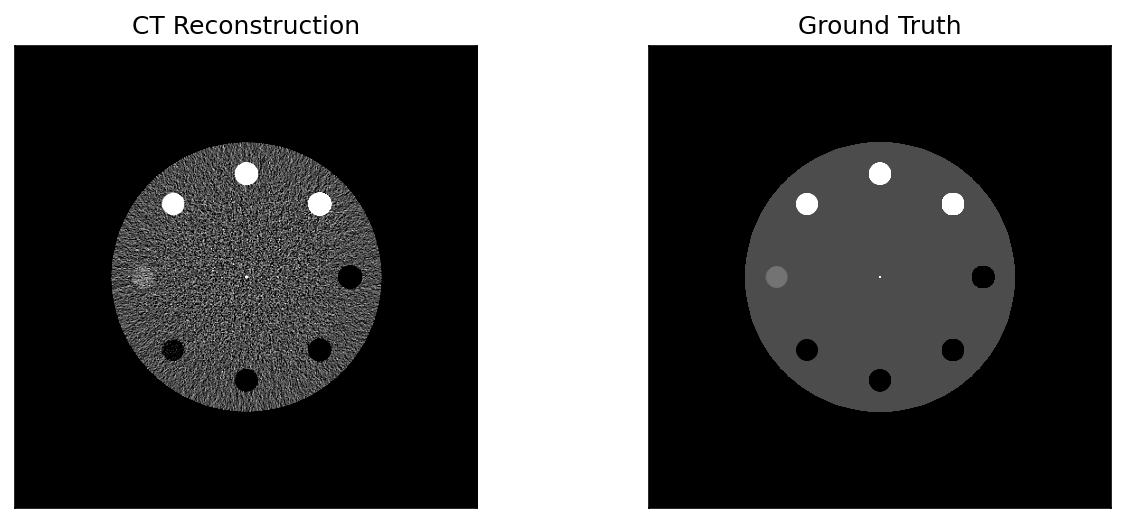

In [9]:
plt.figure(figsize=(10,4), dpi=150)
plt.subplot(1,2,1)
win, lvl = 100, 20
display_settings = (win, lvl)
ctshow(ct.recon[0], display_settings)
plt.title('CT Reconstruction')
plt.subplot(1,2,2)
ctshow(ct.groundtruth, display_settings)
plt.title('Ground Truth')

The `CTobj` ooject also holds the `projections`

Text(0, 0.5, 'detector index')

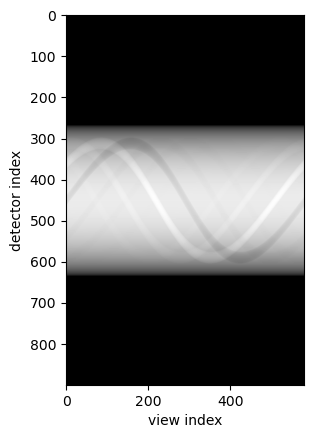

In [10]:
import numpy as np
plt.imshow(-np.log(ct.projections), cmap='gray')
plt.xlabel('view index')
plt.ylabel('detector index')

### Different Phantoms

Here we demonstrate the different phantoms available by defining three CTobj objects each with different phantoms

In [11]:
ctp404 = CTobj('CTP404').run()
cct189 = CTobj('CCT189', I0=3e7).run() # <-- higher dose to show low contrast lesions
uniform = CTobj('uniform').run()







The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ellipse_im: 6 of 10 0.0
ct_sim, simulation: [1/1]
fbp2_back_fan: 80 of 580 0.0
fbp2_back_fan: 159 of 580 0.0
fbp2_back_fan: 238 of 580 0.1
fbp2_back_fan: 317 of 580 0.1
fbp2_back_fan: 397 of 580 0.1
fbp2_back_fan: 476 of 580 0.1
fbp2_back_fan: 556 of 580 0.1






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson

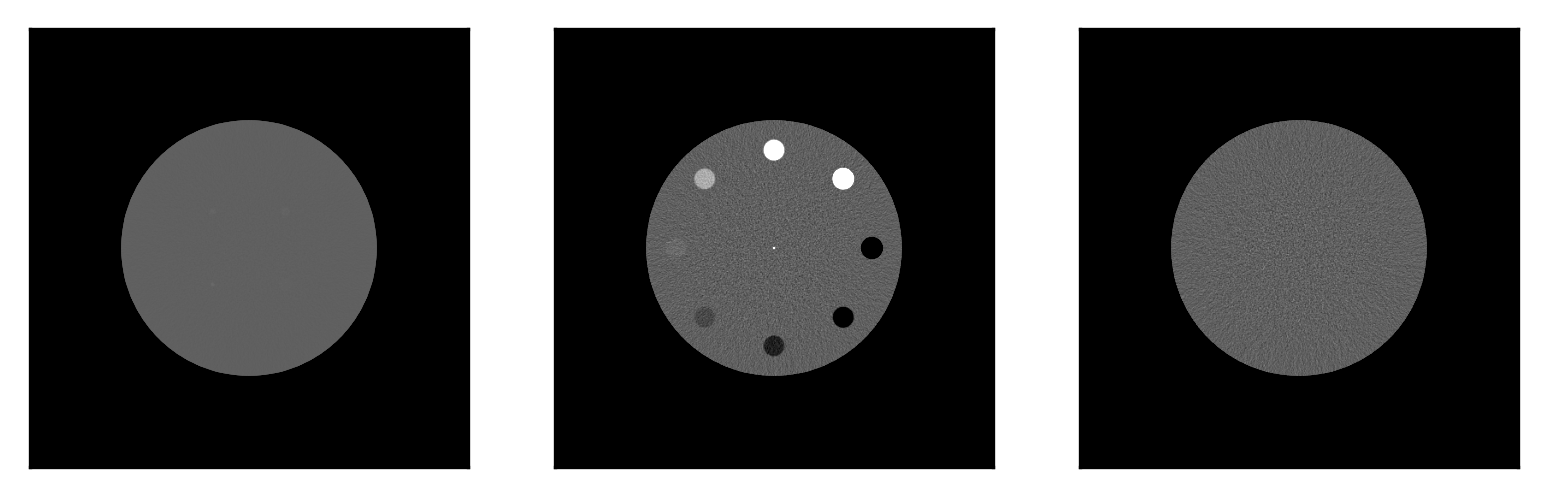

In [12]:
plt.figure(dpi=300)

display_settings =  'soft tissues'

plt.subplot(1,3,1)
ctshow(cct189.recon, display_settings)

plt.subplot(1,3,2)
ctshow(ctp404.recon)

plt.subplot(1,3,3)
ctshow(uniform.recon, display_settings)
plt.show()

### Different Dose Levels

Next let's run a simulation using the `Uniform` phantom but scanned at different dose levels to see how noise trends compare with increasing dose level

In [13]:
import numpy as np
doses = np.linspace(1e5, 8e5, 50)
doses = np.linspace(1e5, 8e5, 3)

res_list = [CTobj('Uniform', I0=I0, nsims=2).run() for I0 in doses]







The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/2]
fbp2_back_fan: 80 of 580 0.0
fbp2_back_fan: 158 of 580 0.0
fbp2_back_fan: 238 of 580 0.1
fbp2_back_fan: 317 of 580 0.1
fbp2_back_fan: 397 of 580 0.1
fbp2_back_fan: 475 of 580 0.1
fbp2_back_fan: 555 of 580 0.1
ct_sim, simulation: [2/2]
fbp2_back_fan: 80 of 580 0.0
fbp2_back_fan: 159 of 580 0.0
fbp2_back_fan: 238 of 580 0.1
fbp2_back_fan: 318 of 580 0.1
fbp2_back_fan: 398 of 580 0.1
fbp2_back_fan: 477 of 580 0.1
fbp2_back_fan: 557 of 580 0.1






The variable "irtdir" is not 

In [14]:
res_list

[<class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 100000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580),
 <class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 450000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580),
 <class 'pediatricIQphantoms.make_phantoms.CTobj'> 20.0 cm Uniform I0: 800000.0
 Recon: (2, 512, 512) 34.0 cm FOV
 Projections: (900, 580)]

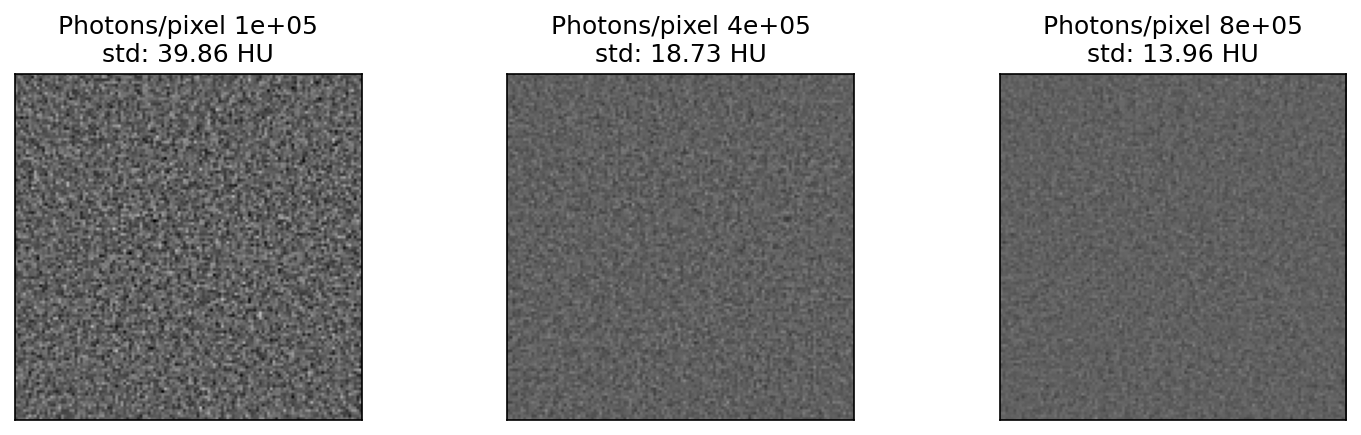

In [15]:
nres = 3
std_noise = []
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    nz, nx, ny = res.recon.shape
    if idx//3 == 0:
        plt.subplot(1, nres, idx+1)
        ctshow(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8], 'soft tissues')
    nz, nx, ny = res.recon.shape
    std_noise.append(res.recon[0, nx//2-nx//8:nx//2+nx//8, nx//2-nx//8:nx//2+nx//8].std())
    plt.title(f'Photons/pixel {doses[idx]:1.1g}\nstd: {std_noise[idx]:2.2f} HU')

Text(0.5, 0, 'Dose Level [%]')

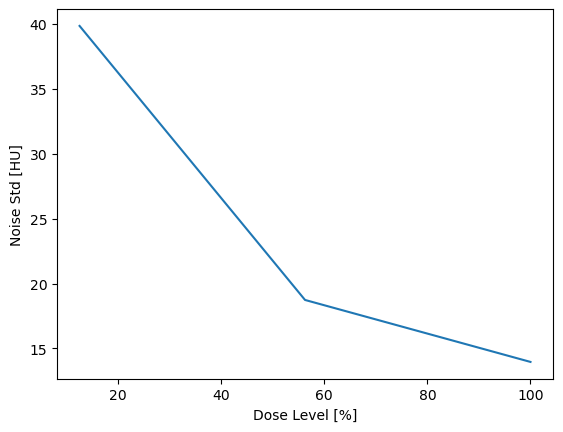

In [16]:
rel_doses = doses/doses.max()*100
plt.plot(rel_doses, std_noise)
plt.ylabel('Noise Std [HU]')
plt.xlabel('Dose Level [%]')

In [17]:
from pathlib import Path
writedir=Path('data/test')
fnames=[]
for res in res_list:
    fname = res.write_to_dicom(writedir / f'{res.seriesname}.dcm')
    fnames += fname
fnames

[PosixPath('data/test/20.0 cm Uniform I0: 100000.0_000.dcm'),
 PosixPath('data/test/20.0 cm Uniform I0: 100000.0_001.dcm'),
 PosixPath('data/test/20.0 cm Uniform I0: 450000.0_000.dcm'),
 PosixPath('data/test/20.0 cm Uniform I0: 450000.0_001.dcm'),
 PosixPath('data/test/20.0 cm Uniform I0: 800000.0_000.dcm'),
 PosixPath('data/test/20.0 cm Uniform I0: 800000.0_001.dcm')]

### Recon Type

In MIRT convolution kernels are specified as `<window function>,<cutoff frequency mm>` for example a typical sharp kernel can be defined as 'hanning,2.05' where a [Hann window](https://en.wikipedia.org/wiki/Hann_function) with a cuffoff ([MTF](https://www.sciencedirect.com/topics/physics-and-astronomy/modulation-transfer-function#:~:text=The%20modulation%20transfer%20function%20(MTF,gets%20transferred%20to%20the%20image.)=0) frequency of 2.05 mm. The table below provides a few Siemen's equivalent kernels based upon matching 50% and 10% MTF cutoffs ([Zeng et al 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430)).

| Description | MIRT         | Siemen's Equivalent |
|:-----------:|--------------|---------------------|
| Sharp       | hanning,2.05 | D45                 |
| Smooth      | hanning,0.85 | B30               

The following experiment runs simulations on increasingly higher cutoff frequency kernels ranging from smooth to sharp.  |

In [18]:
cutoff_freq = [0.5, 0.85, 2.05]

res_list = [CTobj('CCT189', I0=1e6, fbp_kernel=f'hanning,{freq:1.2f}').run() for freq in cutoff_freq]    







The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/1]
fbp2_back_fan: 81 of 580 0.0
fbp2_back_fan: 161 of 580 0.0
fbp2_back_fan: 241 of 580 0.1
fbp2_back_fan: 321 of 580 0.1
fbp2_back_fan: 401 of 580 0.1
fbp2_back_fan: 480 of 580 0.1
fbp2_back_fan: 560 of 580 0.1






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_

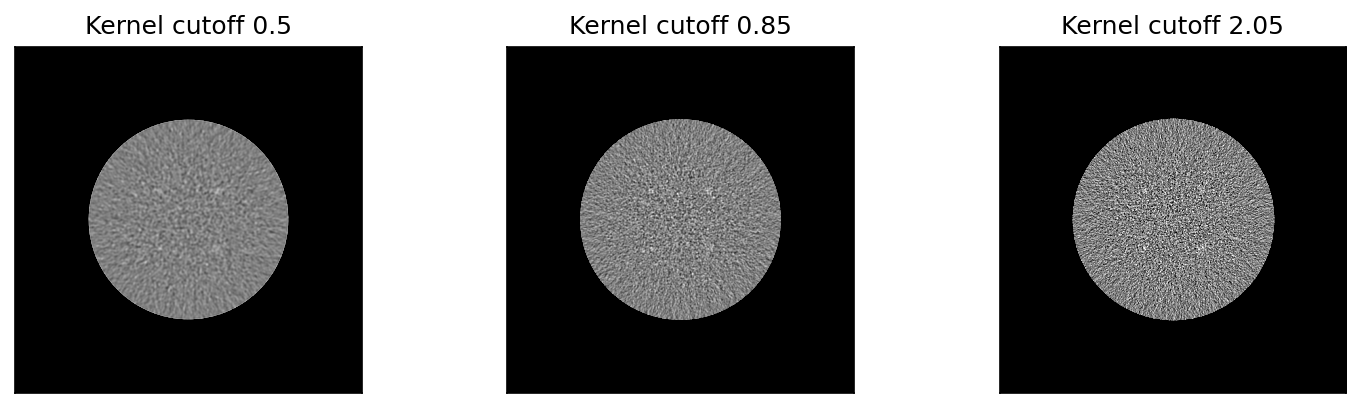

In [19]:
nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, (40, 0))
    plt.title(f'Kernel cutoff {cutoff_freq[idx]}')

### Phantom Size and FOV

Finally let's see how noise texture changes as a result of imaging different sized phantoms with body fitting field of views (FOV)s.

In [20]:
phantom_diameters = [112, 185, 292]

res_list = [CTobj('CCT189', I0=1e6, patient_diameter=d).run() for d in phantom_diameters]   







The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/1]
fbp2_back_fan: 83 of 580 0.0
fbp2_back_fan: 166 of 580 0.0
fbp2_back_fan: 249 of 580 0.1
fbp2_back_fan: 332 of 580 0.1
fbp2_back_fan: 415 of 580 0.1
fbp2_back_fan: 498 of 580 0.1






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/

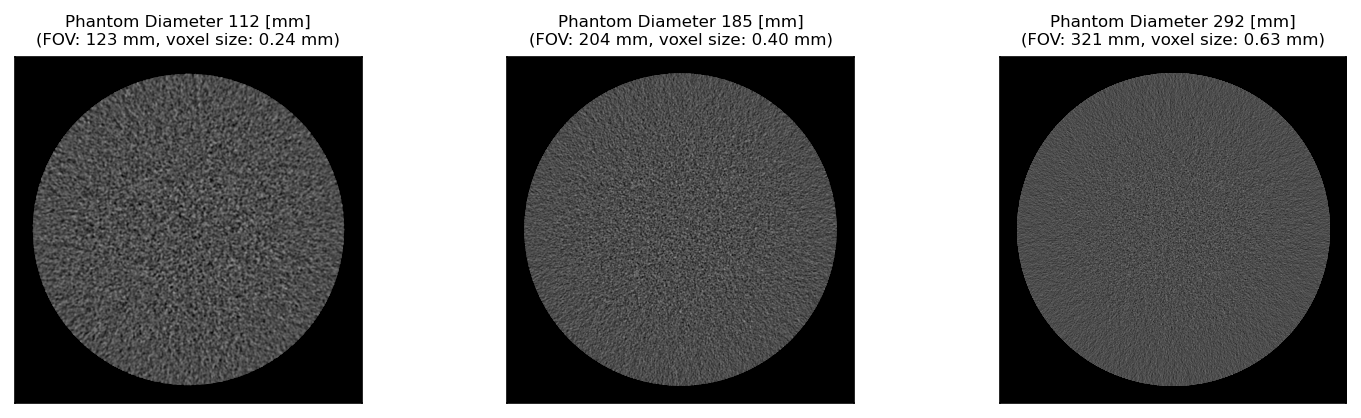

In [21]:
fov = np.array(phantom_diameters)*1.1 # in mm
dx = fov/res.recon.shape[-1]

nres = len(res_list)
plt.figure(figsize=(nres*4, nres), dpi=150)
for idx, res in enumerate(res_list):
    plt.subplot(1, nres, idx+1)
    ctshow(res.recon, 'liver')
    plt.title(f'Phantom Diameter {phantom_diameters[idx]} [mm]\n(FOV: {fov[idx]:2.0f} mm, voxel size: {dx[idx]:2.2f} mm)', fontsize=8)

By default when FOV is not specified, it defaults to a body fitting 1.1x the phantom diameter. Note how FOV changes the relative pixel size

## Batch Mode Simulations

The following introduces how to interactively construct batch simulations in a python environment using [`run_batch_sim`](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L178)

In [22]:
from pediatricIQphantoms import run_batch_sim

In [23]:
run_batch_sim?

Signature:
run_batch_sim(
    image_directory: str,
    model=['CCT189'],
    diameter=[200],
    reference_diameter=200,
    framework='MIRT',
    nsims=1,
    nangles=580,
    aec_on=True,
    add_noise=True,
    full_dose=300000.0,
    dose_level=[1.0],
    sid=595,
    sdd=1085.6,
    nb=880,
    ds=1,
    offset_s=1.25,
    fov=340,
    image_matrix_size=512,
    fbp_kernel='hanning,2.05',
    has_bowtie=True,
)
Docstring:
Running simulations in batch mode

`run_batch_sim` takes lists of parameters (phantoms, diameters, and dose levels) and iterates through all combinations

:param image_directory: Directory to save simulated outputs
:type image_directory: str
:param model: Optional, select phantom model to simulate current options include ['CCT189', 'CTP404']
:type model: list[str]
:param diameter: Optional, simulated phantom diameter in mm
File:      ~/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/make_phantoms.py
Type:      function

Batch mode can be run by either entering in parameter lists for `model`, `diameter`, or `dose_level`

In [24]:
fnames = run_batch_sim(image_directory='data/interactive_batch', dose_level=[0.1, 0.25, 0.5, 1])
fnames

/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/data/interactive_batch
CCT189 Simulation series 0/1






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/1]
fbp2_back_fan: 79 of 580 0.0
fbp2_back_fan: 158 of 580 0.0
fbp2_back_fan: 236 of 580 0.1
fbp2_back_fan: 315 of 580 0.1
fbp2_back_fan: 394 of 580 0.1
fbp2_back_fan: 472 of 580 0.1
fbp2_back_fan: 550 of 580 0.1






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need 

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,20.0 cm CCT189,000,30000.0 photons 20.0 cm CCT189 10% dose fbp D45,0,simulation,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,20.0 cm CCT189,000,75000.0 photons 20.0 cm CCT189 25% dose fbp D45,1,simulation,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,20.0 cm CCT189,000,150000.0 photons 20.0 cm CCT189 50% dose fbp D45,2,simulation,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),50,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,20.0 cm CCT189,000,300000.0 photons 20.0 cm CCT189 100% dose fbp D45,3,simulation,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),100,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,20.0 cm CCT189,000,300000.0 photons 20.0 cm CCT189 100% dose fbp D45,3,noise free,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),None,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
5,20.0 cm CCT189,000,300000.0 photons 20.0 cm CCT189 100% dose fbp D45,3,ground truth,20.0,2,infant,CCT189,Siemens Definition AS+ (simulated),None,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


Alternatively, you can load in a config file and change it as needed and then input to `run_batch_sim` using the [`**` operator](https://realpython.com/python-kwargs-and-args/)

In [25]:
import tomli
with open('../tests/configs/test.toml', 'rb') as f:
    config_file = tomli.load(f)
config_file

{'simulation': [{'image_directory': 'results/test',
   'model': ['CCT189', 'CTP404'],
   'diameter': [112, 292],
   'reference_diameter': 200,
   'framework': 'MIRT',
   'nsims': 2,
   'aec_on': True,
   'add_noise': True,
   'full_dose': 300000.0,
   'dose_level': [0.25, 1.0],
   'sid': 595,
   'sdd': 1085.6,
   'nb': 880,
   'nangles': 100,
   'ds': 1,
   'offset_s': 1.25,
   'fov': 340,
   'image_matrix_size': 256,
   'fbp_kernel': 'hanning,2.05'}]}

In [26]:
config_file.keys(), len(config_file['simulation'])

(dict_keys(['simulation']), 1)

Note: the toml config files are structured to allow multiple simulations with updating select parameters in each simulation, see [Documentation/Usage](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html) for more details.

This for this example, we want to take the first simulation since `run_batch_sim` expects only flat dictionaries, str, float, and int arguments.

In [27]:
config = config_file['simulation'][0]
config

{'image_directory': 'results/test',
 'model': ['CCT189', 'CTP404'],
 'diameter': [112, 292],
 'reference_diameter': 200,
 'framework': 'MIRT',
 'nsims': 2,
 'aec_on': True,
 'add_noise': True,
 'full_dose': 300000.0,
 'dose_level': [0.25, 1.0],
 'sid': 595,
 'sdd': 1085.6,
 'nb': 880,
 'nangles': 100,
 'ds': 1,
 'offset_s': 1.25,
 'fov': 340,
 'image_matrix_size': 256,
 'fbp_kernel': 'hanning,2.05'}

In [28]:
config['image_directory'] = 'data/interactive_batch'
config['dose_level'] = [0.1, 0.25, 0.5, 1]
metadata = run_batch_sim(**config)
metadata

/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/data/interactive_batch
CCT189 Simulation series 0/2






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/2]
ct_sim, simulation: [2/2]






The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/m

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,11.2 cm CCT189,000,30000.0 photons 11.2 cm CCT189 10% dose fbp D45,0,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,11.2 cm CCT189,000,30000.0 photons 11.2 cm CCT189 10% dose fbp D45,0,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),10,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,11.2 cm CCT189,000,75000.0 photons 11.2 cm CCT189 25% dose fbp D45,1,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,11.2 cm CCT189,000,75000.0 photons 11.2 cm CCT189 25% dose fbp D45,1,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,11.2 cm CCT189,000,150000.0 photons 11.2 cm CCT189 50% dose fbp D45,2,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),50,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
5,11.2 cm CCT189,000,150000.0 photons 11.2 cm CCT189 50% dose fbp D45,2,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),50,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
6,11.2 cm CCT189,000,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,3,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
7,11.2 cm CCT189,000,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,3,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
8,11.2 cm CCT189,000,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,3,noise free,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),None,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
9,11.2 cm CCT189,000,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,3,ground truth,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),None,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...


## Command Line Interface Tool: `make_phantoms`

Finally, datasets can be made in batch mode using the command line tool [`make_phantoms`](https://github.com/bnel1201/pediatricIQphantoms/blob/4d3eedd4831ca472b9e76776f4e78ef4a04af430/src/pediatricIQphantoms/make_phantoms.py#L224) that should be available globally in your terminal after pip [installing](https://github.com/bnel1201/pediatricIQphantoms?tab=readme-ov-file#start-here) the `pediatricIQphantoms` package.

In [30]:
!make_phantoms -help

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
usage: make_phantoms [-h] [config]

Make Pediatric IQ Phantoms: command line interface

positional arguments:
  config      input is a configuration .toml file containing simulation
              parameters (see configs/defaults.toml as an example)

options:
  -h, --help  show this help message and exit


For this example we will use [test.toml](../tests/configs/test.toml) as quick example

In [31]:
!cat ../tests/configs/test.toml

# test.toml
[[simulation]]

# directories
image_directory = "results/test"
# filetype = '.mhd' # mhd for metaheader or dcm for dicom
# phantoms
model = ['CCT189', 'CTP404'] # <-- current options include [CCT189, CTP404]
diameter = [112, 292] # <-- units in mm
reference_diameter = 200 # <-- diameter in mm of the real physcial phantom for comparison

# acquisition
framework = "MIRT"
nsims = 2 # <-- number of simulations to perform with different noise instantiations
aec_on = true # (aec built in to ped xcat) <-- 'aec' = automatic exposure control, when `true`, it ensures constant noise levels for all `patient_diameters` (see `reference_dose_level` for more info)
add_noise = true # <-- if true adds Poisson noise, noise magnitude set by `reference_dose_level`, noise texture set by reconstructed field of view (cuttently fov = 110# patient_diameter) 
full_dose = 3e5 # <-- units of photons per pixel
dose_level = [0.25, 1.00] # <-- units of photons, this expression is evaluated by matlab, so k

In [32]:
!make_phantoms ../tests/configs/test.toml

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/notebooks/results/test
CCT189 Simulation series 0/2




The variable "irtdir" is not set, so trying default, assuming
that you launched matlab from the irt install directory.
You may need to edit setup.m or adjust your path otherwise.
Assuming you installed irt in directory "/home/brandon.nelson/Dev/Regulatory_Science_Tools/pediatricIQphantoms/src/pediatricIQphantoms/mirt-main".
Path setup for irt appears to have succeeded.
Warn: sino_geom 154: strip_width=0 is rarely realistic! are you sure?
Warn: sino_geom 156: called from "ct_sim : 26"
ct_sim, simulation: [1/2]
ct_sim, simulation: [2/2]






The variable "irtdir"

## Viewing Images

This last section of the notebook discusses ways to view and interact with the dataset. 

First, below is a demonstration of the directory structure output by `run_batch_sim`:

In [42]:
!tree results/test -P *_000.dcm | head -n 15

results/test
├── CCT189
│   ├── diameter112mm
│   │   ├── dose_025
│   │   │   └── fbp hanning205
│   │   │       └── 11.2 cm CCT189_000.dcm
│   │   └── dose_100
│   │       └── fbp hanning205
│   │           └── 11.2 cm CCT189_000.dcm
│   └── diameter292mm
│       ├── dose_025
│       │   └── fbp hanning205
│       │       └── 29.2 cm CCT189_000.dcm
│       └── dose_100
│           └── fbp hanning205


In [54]:
import pediatricIQphantoms

download_full_dataset = False #Warning: if set to True this will download and take about 3.4 Gb of disk space
if download_full_dataset:
    datadir = Path('data/pediatricIQphantoms/')
    if not datadir.exists():
        download_and_extract_archive(pediatricIQphantoms.URL, download_root=datadir.parent)
else:
    datadir = Path('results/test/')

metadata = pd.read_csv(datadir / 'metadata.csv')
# metadata.file = metadata.file.apply(lambda o: base_dir / o)
metadata

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,11.2 cm CCT189,0,75000.0 photons 11.2 cm CCT189 25% dose fbp D45,0,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
1,11.2 cm CCT189,0,75000.0 photons 11.2 cm CCT189 25% dose fbp D45,0,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
2,11.2 cm CCT189,0,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,1,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
3,11.2 cm CCT189,0,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,1,simulation,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
4,11.2 cm CCT189,0,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,1,noise free,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
5,11.2 cm CCT189,0,300000.0 photons 11.2 cm CCT189 100% dose fbp D45,1,ground truth,11.2,2,infant,CCT189,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
6,29.2 cm CCT189,1,75000.0 photons 29.2 cm CCT189 25% dose fbp D45,0,simulation,29.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
7,29.2 cm CCT189,1,75000.0 photons 29.2 cm CCT189 25% dose fbp D45,0,simulation,29.2,2,infant,CCT189,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...
8,29.2 cm CCT189,1,300000.0 photons 29.2 cm CCT189 100% dose fbp D45,1,simulation,29.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,0,/home/brandon.nelson/Dev/Regulatory_Science_To...
9,29.2 cm CCT189,1,300000.0 photons 29.2 cm CCT189 100% dose fbp D45,1,simulation,29.2,2,infant,CCT189,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,1,/home/brandon.nelson/Dev/Regulatory_Science_To...


In [55]:
import matplotlib.pyplot as plt
import pydicom
if download_full_dataset:
    row = metadata[(metadata['Dose [%]']==25) &
                   (metadata['phantom'] == 'MITA-LCD') &
                   (metadata['recon'] == 'fbp') &
                   (metadata['kernel'] == 'D45') &
                   (metadata['FOV [cm]'] == 32.0) &
                   (metadata['repeat'] == 0)]
    dcm_file = row.file.item()
    dcm = pydicom.dcmread(dcm_file)
    img = dcm.pixel_array + int(dcm.RescaleIntercept)
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.show()
    row

In [38]:
dcm.ImageType

['ORIGINAL', 'PRIMARY', 'AXIAL']

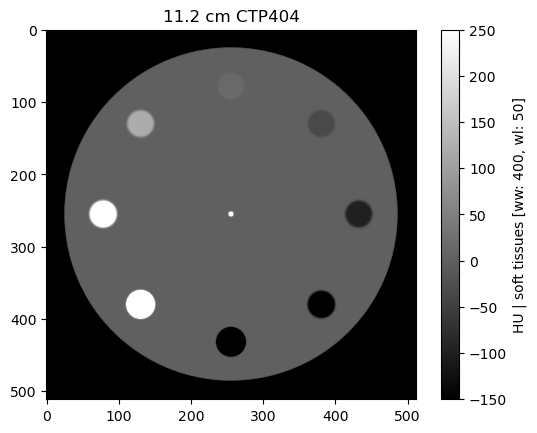

In [39]:
from utils import browse_studies
browse_studies(metadata, phantom='CTP404', fov=12.3, dose=100, recon='noise free', kernel='D45', repeat=0, display='soft tissues')

In [40]:
from utils import study_viewer

In [41]:
study_viewer(metadata)

FOV 12.0 not in [12.3, 14.4, 16.6, 20.4, 23.8, 32.1, 34.0, 38.5]


interactive(children=(Dropdown(description='phantom', options=('CTP404', 'MITA-LCD', 'uniform'), value='CTP404…

### Viewing with Slicer

**Drag and drop the unzipped dataset** into [3D Slicer](https://www.slicer.org/) to automatically load the dataset into [Slicer's DICOM database](https://slicer.readthedocs.io/en/latest/user_guide/modules/dicom.html)

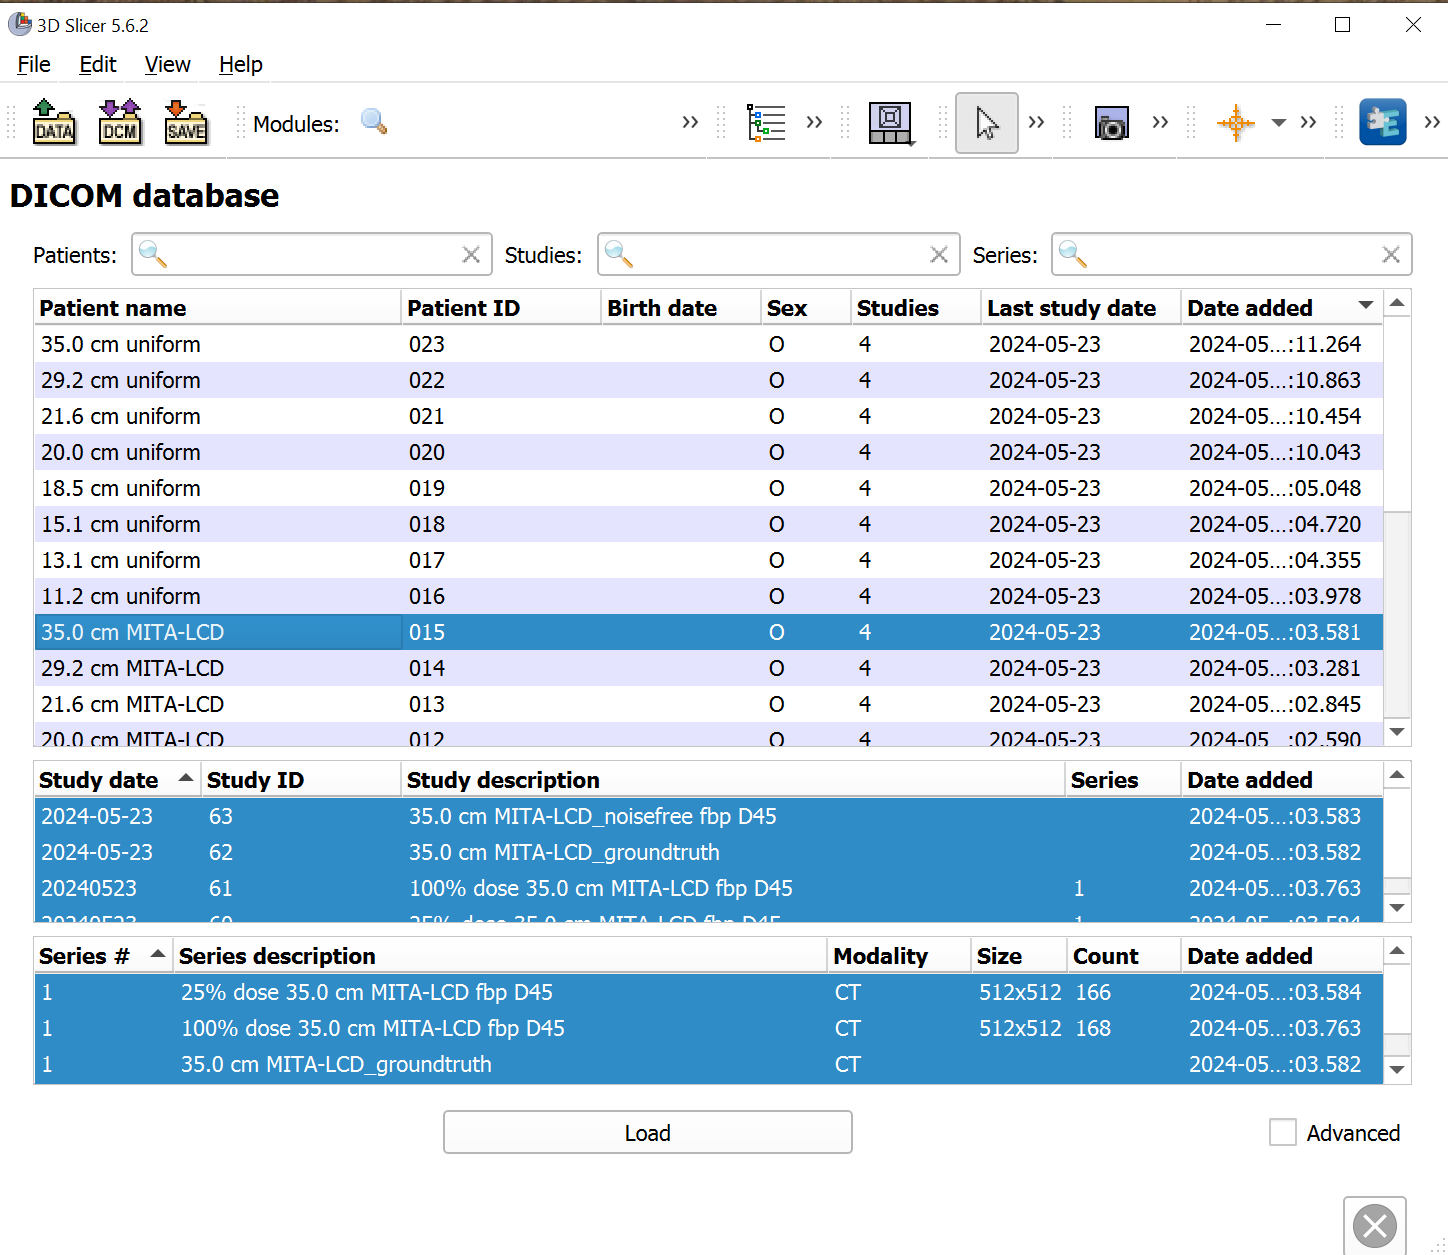

![](slicer_preview.png)

### Radiant (paid)
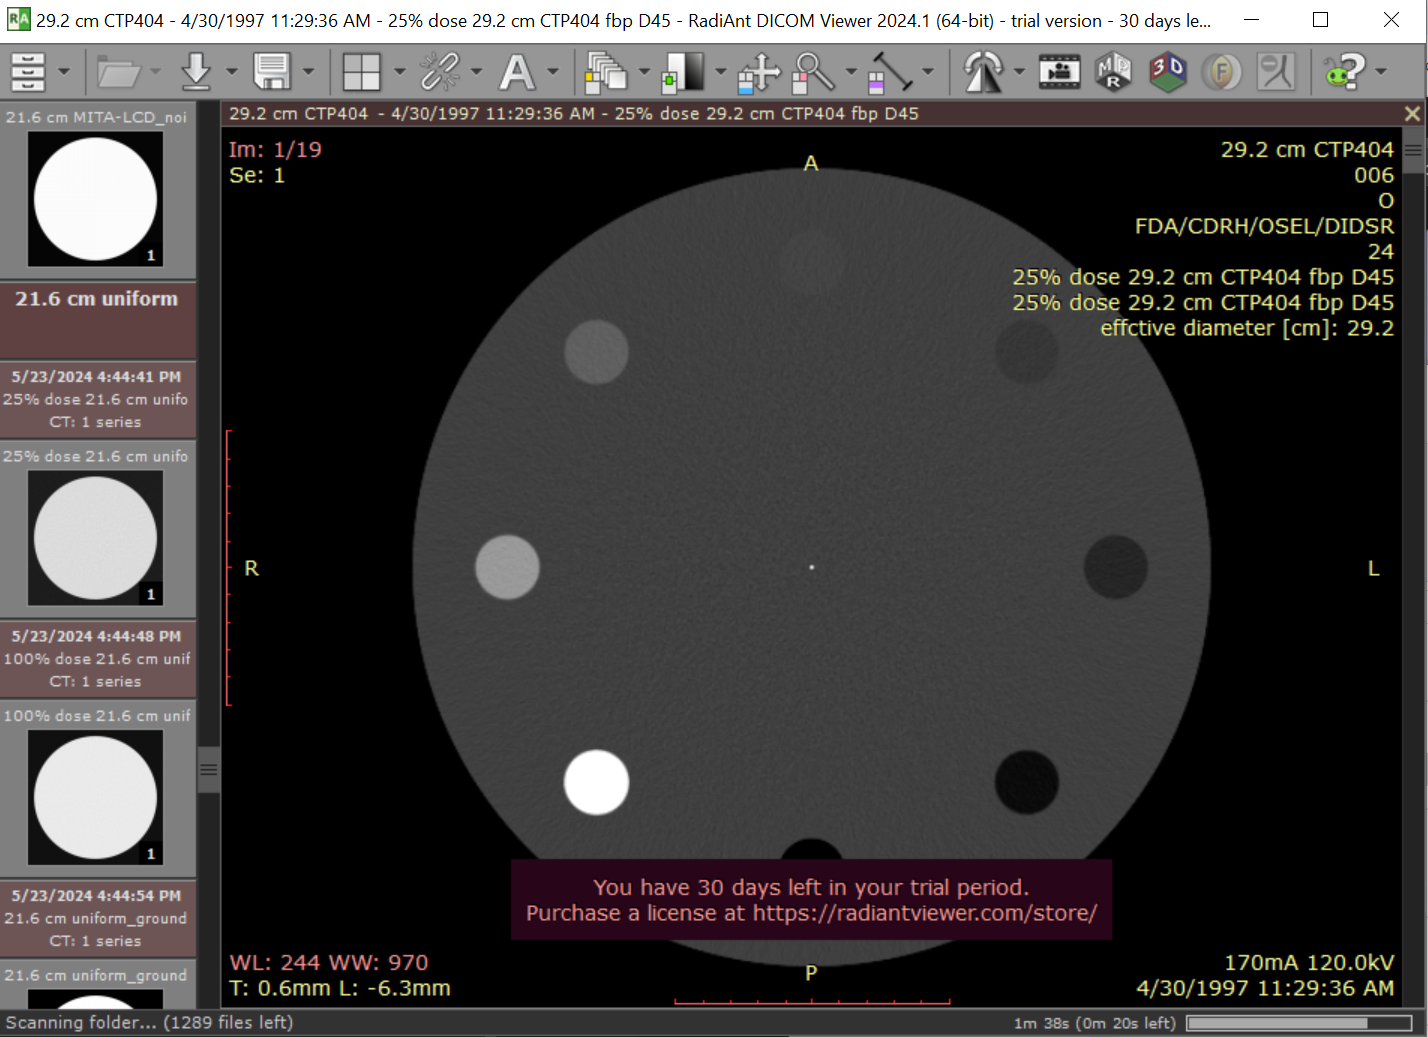

### Other Viewers
1. [Radiant](https://www.radiantviewer.com/) *Note*: this is a [freemium](https://en.wikipedia.org/wiki/Freemium) product
2. [SNAP ITK](http://www.itksnap.org/pmwiki/pmwiki.php?n=Main.HomePage)
3. [Fiji/ImageJ](https://imagej.net/software/fiji/)